# 🕵️ Fake Job Postings Detection

This notebook presents an end-to-end machine learning project for detecting fraudulent job postings.
The goal is to classify job advertisements as **real** or **fraudulent** using textual information.

The project focuses not only on model accuracy, but also on:
- Handling class imbalance
- Interpreting model behavior
- Making decision-aware predictions using probability thresholds


## 1. Imports and Environment Setup

In this section, we import all required libraries for data handling, text processing,
machine learning, and visualization. These libraries will be used throughout the notebook.


In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve
)
import re
import joblib

## 2. Data Loading and Initial Inspection

The dataset is loaded from a CSV file containing job postings and their corresponding labels.
We perform basic inspection to understand the size and structure of the data.


In [255]:
df = pd.read_csv("fake_job_postings.csv")

In [256]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## 3. Understanding the Target Variable

Here we analyze the distribution of the target variable (`fraudulent`) to understand
whether the dataset is balanced or imbalanced. This step is critical because it directly
affects model evaluation and decision-making strategies.


In [257]:
print(df.shape)
print(df.columns)
print(df['fraudulent'].value_counts())

(17880, 18)
Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')
fraudulent
0    17014
1      866
Name: count, dtype: int64


**Target Variable Distribution**
First, let's look at the distribution of our target variable (`fraudulent`). This will help us understand if we are dealing with an imbalanced dataset, which is a common challenge in fraud detection.

/tmp/ipython-input-3523429599.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='fraudulent', palette='Set2')


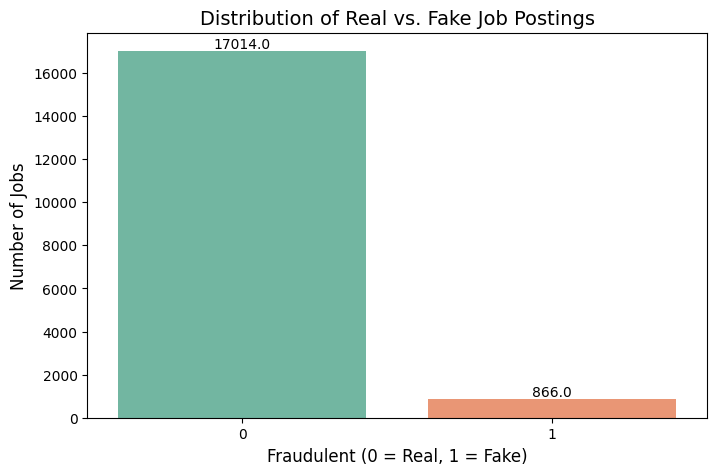

In [258]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x='fraudulent', palette='Set2')
plt.title('Distribution of Real vs. Fake Job Postings', fontsize=14)
plt.xlabel('Fraudulent (0 = Real, 1 = Fake)', fontsize=12)
plt.ylabel('Number of Jobs', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

**Impact of Metadata on Job Authenticity**
Fraudulent job postings might lack professional details like a company logo. Let's visualize the relationship between having a company logo (`has_company_logo`) and whether the job is fake.

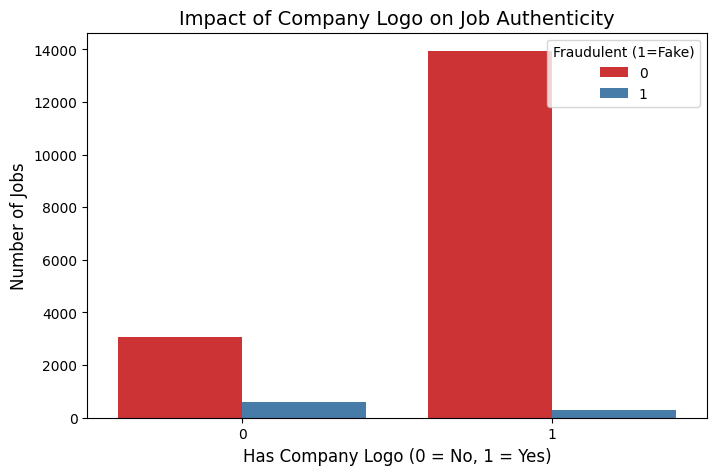

In [259]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='has_company_logo', hue='fraudulent', palette='Set1')
plt.title('Impact of Company Logo on Job Authenticity', fontsize=14)
plt.xlabel('Has Company Logo (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Number of Jobs', fontsize=12)
plt.legend(title='Fraudulent (1=Fake)', loc='upper right')
plt.show()

## 4. Text Column Selection and Cleaning

We select the most informative textual columns (job title, description, and company profile).
Missing values are replaced with empty strings to ensure stable text vectorization later.


In [260]:
text_cols = ['title', 'description', 'company_profile']

In [261]:
df[text_cols] = df[text_cols].fillna("")

## 5. Text Aggregation

All selected text fields are combined into a single column to provide the model
with full contextual information for each job posting.


In [262]:
df['full_text'] = (
    df['title'] + " " +
    df['description'] + " " +
    df['company_profile']
)

In [263]:
X = df['full_text']
y = df['fraudulent']

## 6. Train-Test Split

The dataset is split into training and testing sets using stratification to preserve
the original class distribution of fraudulent and real job postings.


In [264]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## 7. Text Vectorization using TF-IDF

We convert raw text into numerical features using TF-IDF vectorization.
Unigrams and bigrams are used to capture both individual terms and meaningful phrases.


In [265]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=15000,
    ngram_range=(1, 2)
)

In [266]:
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## 8. Baseline Model Training

A Logistic Regression classifier is trained as a strong baseline model.
Class weights are adjusted to handle the imbalance between fraudulent and real job postings.


In [267]:
log_model = LogisticRegression(
    max_iter=1000,
    class_weight={0: 1, 1: 5}
)


In [268]:
log_model.fit(X_train_vec, y_train)

LogisticRegression(class_weight={0: 1, 1: 5}, max_iter=1000)

In [269]:
y_probs = log_model.predict_proba(X_test_vec)[:, 1]

## 9. Initial Model Evaluation

The model is evaluated using precision, recall, and F1-score.
Accuracy is not emphasized due to class imbalance.


In [270]:
y_pred_custom = (y_probs >= 0.35).astype(int)

In [271]:
print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.81      0.85      0.83       173

    accuracy                           0.98      3576
   macro avg       0.90      0.92      0.91      3576
weighted avg       0.98      0.98      0.98      3576



## 10. Decision Threshold Selection

The classification threshold is adjusted to prioritize recall
while maintaining acceptable precision.


In [272]:
for t in [0.5, 0.45, 0.4, 0.35, 0.3]:
    y_pred_t = (y_probs >= t).astype(int)
    print(f"\nThreshold = {t}")
    print(classification_report(y_test, y_pred_t))


Threshold = 0.5
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.93      0.80      0.86       173

    accuracy                           0.99      3576
   macro avg       0.96      0.90      0.93      3576
weighted avg       0.99      0.99      0.99      3576


Threshold = 0.45
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.90      0.82      0.86       173

    accuracy                           0.99      3576
   macro avg       0.95      0.91      0.93      3576
weighted avg       0.99      0.99      0.99      3576


Threshold = 0.4
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.86      0.83      0.84       173

    accuracy                           0.99      3576
   macro avg       0.93      0.91      0.92      3576
weighted avg       0.9

In [273]:
FINAL_THRESHOLD = 0.35

## 11. Model Behavior Analysis

Probability distributions and precision-recall curves are analyzed
to validate stable and consistent model behavior.


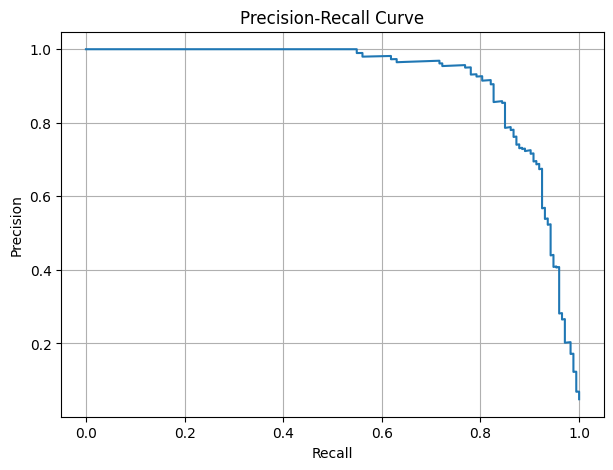

In [274]:
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(7,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()

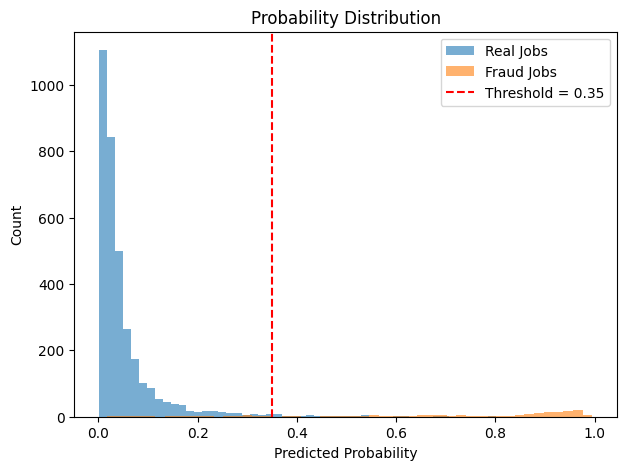

In [275]:
plt.figure(figsize=(7,5))

plt.hist(y_probs[y_test == 0], bins=50, alpha=0.6, label="Real Jobs")
plt.hist(y_probs[y_test == 1], bins=50, alpha=0.6, label="Fraud Jobs")

plt.axvline(0.35, color='red', linestyle='--', label='Threshold = 0.35')
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Probability Distribution")
plt.legend()
plt.show()

In [276]:
results_df = pd.DataFrame({
    "text": X_test,
    "y_true": y_test,
    "prob": y_probs
})

results_df["y_pred"] = (results_df["prob"] >= FINAL_THRESHOLD).astype(int)

In [277]:
false_negatives = results_df[
    (results_df.y_true == 1) & (results_df.y_pred == 0)
].sort_values("prob", ascending=False)

false_negatives.head(3)

,text,y_true,prob,y_pred
11587,SEO Analysis Seeking an SEO Analyst to drive t...,1,0.341586,0
16860,Process Validation Project Manager Responsibi...,1,0.339263,0
17546,Sales/marketing/advertising sales professional...,1,0.331913,0


In [278]:
false_positives = results_df[
    (results_df.y_true == 0) & (results_df.y_pred == 1)
].sort_values("prob", ascending=False)

false_positives.head(3)

,text,y_true,prob,y_pred
536,Part-Time Administrative/Data Entry I As Part ...,0,0.801820,1
16970,Customer Service - Work From Home Do you have ...,0,0.790975,1
4169,BIOMEDICAL EQUIPMENT TECHNICAN St Francis Hosp...,0,0.691539,1


## 12. Manual Inference Tests

The trained model is tested on handcrafted examples
to demonstrate real-world inference behavior.


In [279]:
test_jobs = [
    # Obvious Scam
    """Work from home opportunity!
    No experience required.
    Earn quick money from your laptop.
    Limited positions available.
    Get paid weekly.""",

    # Real Job
    """Software Engineer position at a mid-sized tech company.
    Responsibilities include backend development using Python and REST APIs.
    Bachelor's degree in Computer Science required.
    Health insurance and paid vacation included.""",

    # Grey area
    """Sales Partner opportunity for motivated individuals.
    Flexible working hours.
    Performance-based compensation.
    Strong communication skills required."""
]


In [280]:
X_manual_vec = vectorizer.transform(test_jobs)
manual_probs = log_model.predict_proba(X_manual_vec)[:, 1]

for i, prob in enumerate(manual_probs):
    label = "FRAUD" if prob >= FINAL_THRESHOLD else "REAL"
    print(f"Job {i+1}: Probability={prob:.3f} → {label}")

Job 1: Probability=0.955 → FRAUD
Job 2: Probability=0.171 → REAL
Job 3: Probability=0.211 → REAL


## 13. Model Saving

The trained vectorizer and classification model are saved to disk
to enable reuse during inference without retraining.


In [281]:
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")
joblib.dump(log_model, "logistic_fraud_model.joblib")

['logistic_fraud_model.joblib']

## 14. Conclusion

In this notebook, we developed an end-to-end machine learning pipeline for detecting fraudulent job postings using textual data.

The project began with an analysis of the dataset, highlighting a strong class imbalance that required careful evaluation beyond simple accuracy metrics. Textual information from job titles, descriptions, and company profiles was combined and transformed using TF-IDF vectorization, providing a robust representation for classification.

A Logistic Regression model was trained as a strong and interpretable baseline. Due to the imbalanced nature of the problem, recall for fraudulent postings was prioritized. Instead of relying on the default decision threshold, we tuned the probability threshold to achieve a more suitable balance between recall and precision.

Further analysis of model behavior, including precision–recall curves, probability distributions, and error inspection, showed that the model behaves consistently and predictably. Most classification errors occur in ambiguous job postings that are also challenging for human reviewers, indicating realistic and reliable model behavior.

Finally, manual inference tests were performed on handcrafted examples to simulate real-world usage. The results confirmed that the model assigns high confidence to clearly fraudulent postings, low confidence to legitimate jobs, and intermediate probabilities to borderline cases.

Overall, this project demonstrates not only the construction of an effective text-based classifier, but also a decision-aware approach to machine learning that emphasizes interpretability, controlled trade-offs, and practical deployment considerations.
